In [1]:
!pip install einops -q

     |████████████████████████████████| 41 kB 301 kB/s 


In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 31.6 MB/s 
     |████████████████████████████████| 182 kB 74.2 MB/s 
     |████████████████████████████████| 174 kB 68.6 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 173 kB 74.4 MB/s 
     |████████████████████████████████| 168 kB 83.3 MB/s 
     |████████████████████████████████| 168 kB 81.2 MB/s 
     |████████████████████████████████| 166 kB 84.6 MB/s 
     |████████████████████████████████| 166 kB 83.9 MB/s 
     |████████████████████████████████| 162 kB 82.7 MB/s 
     |████████████████████████████████| 162 kB 63.0 MB/s 
     |████████████████████████████████| 158 kB 74.0 MB/s 
     |████████████████████████████████| 157 kB 84.8 MB/s 
     |████████████████████████████████| 157 kB 83.6 MB/s 
     |████████████████████████████████| 157 kB 86.3 MB/s 
     |███████████████████████████

In [3]:
from typing import Callable
import time
import random
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb

from PIL import Image
from einops import rearrange, reduce, repeat
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100

In [4]:
class MSA(nn.Module):
    """Multi-head Self Attention Block"""

    def __init__(
        self, heads: int, emb_dim: int, 
        dropout: float = 0., attention_dropout: float = 0.
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.n_h = heads
        self.head_dim = self.emb_dim // self.n_h
        self.q = nn.Linear(self.emb_dim, self.emb_dim)
        self.k = nn.Linear(self.emb_dim, self.emb_dim)
        self.v = nn.Linear(self.emb_dim, self.emb_dim)
        self.attention_dropout = nn.Dropout(attention_dropout)
        self.linear_projection = nn.Linear(self.emb_dim, self.emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        # (bs,     s_l,      e_d)
        batch_s, seq_len, emb_dim = x.shape
        # (bs, s_l, e_d) -> (bs, s_l, n_h, h_d) -> (bs, n_h, s_l, h_d)
        x_q = self.q(x).view(
            batch_s, seq_len, self.n_h, self.head_dim).transpose(1, 2)
        x_k = self.k(x).view(
            batch_s, seq_len, self.n_h, self.head_dim).transpose(1, 2)
        x_v = self.v(x).view(
            batch_s, seq_len, self.n_h, self.head_dim).transpose(1, 2)
        # @ operator is the convention for matrix multiplication, throughout python
        # q @ k.T -> (bs, n_h, s_l, h_d) @ (bs, n_h, h_d, s_l) -> (bs, n_h, s_l, s_l)
        # Softmax((q @ k.T)/root(h_d)) @ v
        #   -> (bs, n_h, s_l, s_l) @ (bs, n_h, s_l, h_d) -> (bs, n_h, s_l, h_d)
        attention = (x_q @ x_k.transpose(-2, -1)) / math.sqrt(x_q.size(-1))
        attention = F.softmax(attention, dim=-1)
        attention = self.attention_dropout(attention)
        # (bs, n_h, s_l, h_d) -> (bs, s_l, n_h, h_d) -> (bs, s_l, e_d)
        x = (attention @ x_v).transpose(1, 2).reshape(batch_s, seq_len, emb_dim)
        x = self.linear_projection(x)
        x = self.dropout(x)
        return x

In [5]:
class MLP(nn.Module):
    """MLP block"""

    def __init__(self, emb_dim: int, feat_dim: int, dropout: float = 0):
        super().__init__()
        self.layer1 = nn.Linear(emb_dim, feat_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.layer2 = nn.Linear(feat_dim, emb_dim)

        # below init from torchvision
        nn.init.xavier_uniform_(self.layer1.weight)
        nn.init.xavier_uniform_(self.layer2.weight)
        nn.init.normal_(self.layer1.bias, std=1e-6)
        nn.init.normal_(self.layer2.bias, std=1e-6)

    def forward(self, x: torch.Tensor):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        return x

In [6]:
class TransformerEncoderBlock(nn.Module):
    """Transformer Encoder Block"""

    def __init__(
        self, n_h: int, emb_dim: int, feat_dim: int, 
        dropout: float = 0, attention_dropout: float = 0
    ):
        super().__init__()
        self.msa = MSA(heads=n_h, emb_dim=emb_dim, dropout=dropout, attention_dropout=attention_dropout)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.ffn = MLP(emb_dim, feat_dim, dropout)
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x: torch.Tensor):
        identity = x
        x = self.msa(x)
        x += identity
        x = self.norm1(x)
        identity = x
        x = self.ffn(x)
        x += identity
        x = self.norm2(x)
        return x

In [36]:
class ViT(nn.Module):
    """
        Vison Transformer (ViT) Model
        https://arxiv.org/abs/2010.11929
    """

    def __init__(
        self, heads: int = 12, emb_dim: int = 768, feat_dim: int = 3072, 
        dropout: float = 0, layers: int = 12, patch_size: int = 16, 
        channels: int = 3, image_size: int = 224, num_class: int = 1000 , 
    ):
        super().__init__()
        self.patch_size = patch_size
        self.image_size = image_size
        self.linear_projection = nn.Linear(
            self.patch_size*self.patch_size*channels, emb_dim)
        self.class_token = nn.Parameter(torch.randn([1, 1, emb_dim]))
        self.pos_emb = nn.Parameter(
            torch.randn(
                [1, self.image_size // patch_size * self.image_size // patch_size + 1, emb_dim]
            ).normal_(std=0.02) # init from torchvision, which is inspired by BERT
        )
        self.dropout = nn.Dropout(dropout)
        encoders = []
        for _ in range(0, layers):
            encoders.append(
                TransformerEncoderBlock(
                    n_h=heads, emb_dim=emb_dim, feat_dim=feat_dim,
                    dropout=dropout
                )
            )
        self.encoder_stack = nn.Sequential(*encoders)
        self.mlp_head = nn.Linear(emb_dim, num_class)

    def forward(self, x: torch.Tensor , test = False):
        bs, c, h, w = x.shape  # (bs, c, h, w)
        torch._assert(h*w == self.image_size**2, "image size mismatch")
        torch._assert(
            (self.image_size ** 2) % (self.patch_size ** 2) == 0, 
            "image not disivible by patch_size"
        )

        # below 2 lines creates patches using view/reshape and permutations
        # (bs, c, no_of_patches, patch_h, no_of_patches, patch_w) 
        #   -> (bs, no_of_patches, no_of_patches, c, patch_h, patch_w)
        x = x.view(
            bs, c, h // self.patch_size, self.patch_size, 
            w // self.patch_size, self.patch_size
        ).permute(0, 2, 4, 1, 3, 5)
        # (bs, no_of_patches*no_of_patches, c*patch_h*patch_w)
        x = x.reshape(
            bs, h // self.patch_size * w // self.patch_size, 
            c*self.patch_size*self.patch_size
        )

        # linear projection to embedding dimension
        x = self.linear_projection(x)

        # this expands/repeats the [class] token for each batch. Expand uses less memory
        # alternative: self.batch_class_token.repeat((bs, 1, 1), 1)
        batch_class_token = self.class_token.expand(bs, -1, -1)

        # appends sequence to the [class] token (dimension 1) 
        # (bs, seq_len, emb_dim) -> (bs, seq_len + 1, emb_dim)
        x = torch.cat((batch_class_token, x), 1)

        # expands position embedding batch wise, add embedding dropout
        x = self.pos_emb.expand(bs, -1, -1) + x
        x = self.dropout(x)

        # sequentially pass through all encoders
        x = self.encoder_stack(x)

        # collect output from [class] token
        xx = x[:, 0]

        # send it through MLP head to get logits
        xx = self.mlp_head(xx)
        if test:
          return xx ,x 
        return xx

In [22]:
class ConvTokenizer(nn.Module):
    def __init__(
        self,
        channels: int = 3, emb_dim: int = 256,
        conv_kernel: int = 3, conv_stride: int = 2, conv_pad: int = 3,
        pool_kernel: int = 3, pool_stride: int = 2, pool_pad: int = 1,
        activation: Callable = nn.ReLU
    ):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=channels, out_channels=emb_dim,
            kernel_size=conv_kernel, stride=conv_stride,
            padding=(conv_pad, conv_pad)
        )
        self.act = activation(inplace=True)
        self.max_pool = nn.MaxPool2d(
            kernel_size=pool_kernel, stride=pool_stride, 
            padding=pool_pad
        )
            
    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.act(x)
        x = self.max_pool(x)
        return x

In [23]:
x = torch.randn([1, 3, 32, 32])
t = ConvTokenizer()
t(x).shape

torch.Size([1, 256, 9, 9])

In [24]:
class SeqPool(nn.Module):
    def __init__(self, emb_dim=256):
        super().__init__()
        self.dense = nn.Linear(emb_dim, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        bs, seq_len, emb_dim = x.shape
        identity = x
        x = self.dense(x)
        x = rearrange(
            x, 'bs seq_len 1 -> bs 1 seq_len', seq_len=seq_len
        )
        x = self.softmax(x)
        x = x @ identity
        x = rearrange(
            x, 'bs 1 e_d -> bs e_d', e_d=emb_dim
        )
        return x

In [25]:
x = torch.randn([8, 36, 256])
p = SeqPool()
p(x).shape

torch.Size([8, 256])

In [26]:
class CCT(nn.Module):
    """
        Compact Convolutional Transformer (CCT) Model
        https://arxiv.org/abs/2104.05704v4
    """    
    def __init__(
        self,
        conv_kernel: int = 3, conv_stride: int = 2, conv_pad: int = 3,
        pool_kernel: int = 3, pool_stride: int = 2, pool_pad: int = 1,
        heads: int = 4, emb_dim: int = 256, feat_dim: int = 2*256, 
        dropout: float = 0.1, attention_dropout: float = 0.1, layers: int = 7, 
        channels: int = 3, image_size: int = 32, num_class: int = 10
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.image_size = image_size

        self.tokenizer = ConvTokenizer(
            channels=channels, emb_dim=self.emb_dim,
            conv_kernel=conv_kernel, conv_stride=conv_stride, conv_pad=conv_pad,
            pool_kernel=pool_kernel, pool_stride=pool_stride, pool_pad=pool_pad,
            activation=nn.ReLU
        )

        with torch.no_grad():
            x = torch.randn([1, channels, image_size, image_size])
            out = self.tokenizer(x)
            _, _, ph_c, pw_c  = out.shape

        self.linear_projection = nn.Linear(
            ph_c, pw_c, self.emb_dim
        )

        self.pos_emb = nn.Parameter(
            torch.randn(
                [1, ph_c*pw_c, self.emb_dim]
            ).normal_(std=0.02) # from torchvision, which takes this from BERT
        )
        self.dropout = nn.Dropout(dropout)
        encoders = []
        for _ in range(0, layers):
            encoders.append(
                TransformerEncoderBlock(
                    n_h=heads, emb_dim=self.emb_dim, feat_dim=feat_dim,
                    dropout=dropout, attention_dropout=attention_dropout
                )
            )
        self.encoder_stack = nn.Sequential(*encoders)
        self.seq_pool = SeqPool(emb_dim=self.emb_dim)
        self.mlp_head = nn.Linear(self.emb_dim, num_class)


    def forward(self, x: torch.Tensor):     
        bs, c, h, w = x.shape  # (bs, c, h, w)

        # Creates overlapping patches using ConvNet
        x = self.tokenizer(x)
        x = rearrange(
            x, 'bs e_d ph_h ph_w -> bs (ph_h ph_w) e_d', 
            bs=bs, e_d=self.emb_dim
        )

        # Add position embedding
        x = self.pos_emb.expand(bs, -1, -1) + x
        x = self.dropout(x)

        # Pass through Transformer Encoder layers
        x = self.encoder_stack(x)

        # Perform Sequential Pooling <- Novelty of the paper
        x = self.seq_pool(x)

        # MLP head used to get logits
        x = self.mlp_head(x)

        return x

In [27]:
x = torch.randn([8, 3, 32, 32])
t = CCT()
t(x).shape

torch.Size([8, 10])

In [28]:
!pip install ptflops -q 

In [29]:
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  macs, params = get_model_complexity_info(t, (3, 32, 32), as_strings=True, print_per_layer_stat=False)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       300.09 MMac
Number of parameters:           3.72 M  


In [30]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

def get_train_transforms(image_size=(32, 32)):
    return transforms.Compose(
        [   
            transforms.RandAugment(),
            transforms.RandomResizedCrop(
                image_size, scale=(0.5, 1.5)
            ),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std, True)
        ]
    )

def get_val_transforms(image_size=(32, 32)):
    return transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean, std, True)
        ]
    )

In [31]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# below func from torchvision
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions 
    for the specified values of k
    """
    with torch.inference_mode():
        maxk = max(topk)
        batch_size = target.size(0)
        if target.ndim == 2:
            target = target.max(dim=1)[1]

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target[None])

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().sum(dtype=torch.float32)
            res.append(correct_k * (100.0 / batch_size))
        return res


def train_one_epoch(
    model, criterion, optimizer, scheduler, data_loader, device
):
    model.train()
    running_loss = 0
    start_time = time.time()
    for image, target in data_loader:
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        running_loss += float(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
    print(f'Elapsed time {(time.time() - start_time):.1f}s')
    return running_loss/len(data_loader)


@torch.inference_mode()
def val_one_epoch(model, criterion, data_loader, device):
    model.eval()
    acc1_list, acc5_list = [], []
    running_loss = 0
    with torch.inference_mode():
        for image, target in data_loader:
            image = image.to(device)
            target = target.to(device)
            output = model(image)
            loss = criterion(output, target)
            running_loss += float(loss.item())
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            acc1_list.append(acc1.detach().cpu().numpy())
            acc5_list.append(acc5.detach().cpu().numpy())

    return (
        running_loss/len(data_loader), 
        np.mean(np.array(acc1_list)), 
        np.mean(np.array(acc5_list))
    )

In [18]:
def train(model, config , train_ds , val_ds  , log=True):
   
   
    train_dl = DataLoader(
        train_ds, batch_size=config['batch_size'], shuffle=True, 
        pin_memory=True, num_workers=config['num_workers'], 
        persistent_workers=True
    )

    val_dl = DataLoader(
        val_ds, batch_size=config['batch_size'], shuffle=False, 
        pin_memory=True, num_workers=config['num_workers']
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=config['lr'], weight_decay=config['weight_decay']
    )
    
    # the authors used cosine annealing scheduler.
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=config['lr'], 
        steps_per_epoch=len(train_dl), epochs=config['max_epoch']
    )
    print('-'*50)
    last_acc1 = 0.0
    for i in range(0, config['max_epoch']):
        loss = train_one_epoch(
            model, criterion, optimizer, scheduler, train_dl, device
        )
        print(f'average train loss for epoch #{i+1} is {loss:.4f}')
        loss, acc1, acc5 = val_one_epoch(model, criterion, val_dl, device)
       
        print(f'average val loss for epoch #{i+1} is {loss:.4f}')
        print(f'average val acc@1 for epoch #{i+1} is {acc1:.4f}')
        print(f'average val acc@5 for epoch #{i+1} is {acc5:.4f}')
        if acc1 > last_acc1:
            last_acc1 = acc1
            torch.save(
                model.state_dict(), 
                f'./cct_epoch_{i+1}_acc_{acc1:.2f}.pth'
            )
        print('-'*50)
    


## on cifar10

In [190]:
config = dict(
    seed=42, # <-- the answer to life, the universe and everything
    heads=4, emb_dim=256, feat_dim=512, layers=7,
    num_class=10, image_size=32,
    dropout=0.1, attention_dropout=0.1,
    batch_size=128, max_epoch=100,
    lr=5e-4, weight_decay=3e-2,
    num_workers=2
)
seed_everything(config['seed'])
wandb.config = config
# model = CCT(
#     heads=config['heads'], emb_dim=config['emb_dim'], 
#     feat_dim=config['feat_dim'], layers=config['layers'],
#     num_class=config['num_class'], image_size=config['image_size'], 
#     dropout=config['dropout'], attention_dropout=config['attention_dropout']
# )


model111 = ViT(  heads=config['heads'], emb_dim=config['emb_dim'], 
            feat_dim=config['feat_dim'], layers=config['layers'], 
            num_class=config['num_class'], image_size=config['image_size'],dropout=config['dropout'])


train_ds = CIFAR10(
        root='/content/data/',
        train=True,
        transform=get_train_transforms(),
        download=True
    ) 
 

val_ds = CIFAR10(
        root='/content/data/',
        train=False,
        transform=get_val_transforms(),
        download=True
    )

train(model111, config , train_ds , val_ds  , log=False)

Files already downloaded and verified
Files already downloaded and verified
--------------------------------------------------
Elapsed time 47.1s
average train loss for epoch #1 is 2.1690
average val loss for epoch #1 is 1.9357
average val acc@1 for epoch #1 is 32.0807
average val acc@5 for epoch #1 is 84.6519
--------------------------------------------------
Elapsed time 44.6s
average train loss for epoch #2 is 2.0714
average val loss for epoch #2 is 1.8797
average val acc@1 for epoch #2 is 35.1266
average val acc@5 for epoch #2 is 86.4814
--------------------------------------------------
Elapsed time 44.9s
average train loss for epoch #3 is 2.0192
average val loss for epoch #3 is 1.8314
average val acc@1 for epoch #3 is 37.5000
average val acc@5 for epoch #3 is 87.7176
--------------------------------------------------
Elapsed time 44.9s
average train loss for epoch #4 is 1.9891
average val loss for epoch #4 is 1.7960
average val acc@1 for epoch #4 is 39.6460
average val acc@5 for 

In [191]:
aaa = []
ttt = []

val_dl = DataLoader(
        val_ds, batch_size=config['batch_size'], shuffle=False, 
        pin_memory=True, num_workers=config['num_workers']
    )


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model111.to(device)




model111.eval()
acc1_list, acc5_list = [], []
running_loss = 0
i = 0
with torch.inference_mode():
    for image, target in val_dl:
        image = image.to(device)
        target = target.to(device)
        output , feature = model111(image , test = True)

        aaa.append(feature.cpu())
        ttt.append(target)
        loss = criterion(output, target)
        running_loss += float(loss.item())
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        acc1_list.append(acc1.detach().cpu().numpy())
        acc5_list.append(acc5.detach().cpu().numpy())
        if i >1 : 
          break
        i+=1

aaa = np.array(aaa)

<ipython-input-191-7ebfa93d22bc>:38: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  aaa = np.array(aaa)
<ipython-input-191-7ebfa93d22bc>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  aaa = np.array(aaa)


In [192]:
aaa = aaa[0]
aaa.shape

torch.Size([128, 5, 256])

In [193]:
aaa = aaa.view(128 , -1)
aaa.shape

torch.Size([128, 1280])

In [194]:
ttt = ttt[0]
len(ttt)

128

In [195]:
aaa[-1,-1]

tensor(-0.2549)

In [196]:
ttt

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3], device='cuda:0')

In [197]:
ttt = ttt.to('cpu').detach().numpy().copy()
aaa = aaa.to('cpu').detach().numpy().copy()

In [198]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 2)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(aaa)


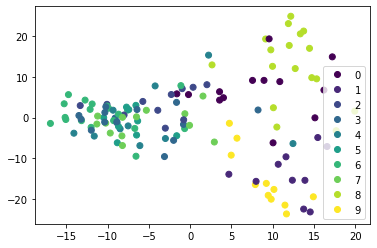

In [199]:
plot = plt.scatter(Xt[:,0], Xt[:,1], c=ttt)
plt.legend(handles=plot.legend_elements()[0], labels=range(10))
plt.show()

In [200]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(aaa)

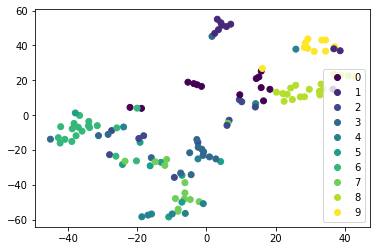

In [201]:
plot = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=ttt)
plt.legend(handles=plot.legend_elements()[0], labels=range(10))
plt.show()

## on cifar100

In [ ]:
config = dict(
    seed=42, # <-- the answer to life, the universe and everything
    heads=4, emb_dim=256, feat_dim=512, layers=7,
    num_class=100, image_size=32,
    dropout=0.1, attention_dropout=0.1,
    batch_size=128, max_epoch=5,
    lr=5e-4, weight_decay=3e-2,
    num_workers=2
)
seed_everything(config['seed'])
wandb.config = config
model = CCT(
    heads=config['heads'], emb_dim=config['emb_dim'], 
    feat_dim=config['feat_dim'], layers=config['layers'],
    num_class=config['num_class'], image_size=config['image_size'], 
    dropout=config['dropout'], attention_dropout=config['attention_dropout']
)


train_ds = CIFAR100(
        root='/content/data/',
        train=True,
        transform=get_train_transforms(),
        download=True
    ) 
 

val_ds = CIFAR100(
        root='/content/data/',
        train=False,
        transform=get_val_transforms(),
        download=True
    )

train(model, config , train_ds , val_ds  , log=False)

Files already downloaded and verified
Files already downloaded and verified
--------------------------------------------------
Elapsed time 48.9s
average train loss for epoch #1 is 4.3304
average val loss for epoch #1 is 3.9395
average val acc@1 for epoch #1 is 11.2737
average val acc@5 for epoch #1 is 33.8113
--------------------------------------------------
Elapsed time 49.0s
average train loss for epoch #2 is 3.9078
average val loss for epoch #2 is 3.5983
average val acc@1 for epoch #2 is 17.8600
average val acc@5 for epoch #2 is 45.1740
--------------------------------------------------
Elapsed time 50.6s
average train loss for epoch #3 is 3.5982
average val loss for epoch #3 is 3.2369
average val acc@1 for epoch #3 is 26.1076
average val acc@5 for epoch #3 is 57.7334
--------------------------------------------------
Elapsed time 49.0s
average train loss for epoch #4 is 3.3372
average val loss for epoch #4 is 3.0485
average val acc@1 for epoch #4 is 31.6357
average val acc@5 for 